# VAR Model for Macroeconomic Analysis

## **Description**:
This Jupyter Notebook is designed as a practical guide for economists, data scientists, and financial analysts interested in applying Vector Autoregression (VAR) models to macroeconomic data. The notebook offers a step-by-step approach to understanding and implementing VAR models, which are essential tools for capturing the dynamic relationships between multiple time series variables. Whether you are analyzing GDP, inflation rates, or interest rates, this notebook provides the framework needed to explore how these variables interact over time.
## **Introduction to VAR Models**:
The notebook begins with an introduction to VAR models, explaining their significance in macroeconomic analysis. VAR models allow for the simultaneous modeling of multiple time series, making them particularly useful for studying the interconnectedness of economic indicators. By treating all variables as endogenous, the VAR approach avoids the need for strong theoretical assumptions about causality, making it a flexible and widely used tool in econometrics.
## **Data Collection and Preparation**:
A critical part of any macroeconomic analysis is the collection and preparation of data. This notebook guides users through the process of acquiring relevant macroeconomic time series data from reliable sources. It also covers essential data cleaning techniques, such as handling missing values and ensuring stationarity, which are prerequisites for accurate VAR modeling. The data preparation section ensures that the user has a robust dataset to work with before moving on to model estimation.
## **Model Specification and Estimation**:
The heart of the notebook is the section on model specification and estimation. Users will learn how to select the appropriate lag length for their VAR model, a crucial step in capturing the temporal dependencies between variables. The notebook also covers the inclusion of exogenous variables and the use of information criteria to refine the model specification. Once the model is specified, detailed instructions are provided for estimating the model parameters, followed by a thorough discussion of diagnostic tests to validate the model's assumptions.
## **Impulse Response Functions and Forecasting**:
One of the key strengths of VAR models is their ability to generate impulse response functions (IRFs), which illustrate how a shock to one variable affects the others over time. The notebook includes practical examples of how to compute and interpret IRFs, providing insights into the dynamic behavior of the macroeconomic system. In addition, the forecasting section demonstrates how to use the fitted VAR model to make predictions about future values of the variables, with examples that highlight the model's forecasting capabilities.
## **Scenario Analysis and Applications**:
Beyond traditional forecasting, the notebook explores the use of VAR models for scenario analysis. By simulating different economic conditions, users can assess the potential impact of various shocks on the macroeconomic variables of interest. This section provides a hands-on approach to understanding how VAR models can be applied in policy analysis, risk management, and other real-world economic contexts.

## Importing Libraries
- **pandas**: 
Used for data manipulation and analysis, providing powerful data structures like DataFrames to handle time series data efficiently.
- **matplotlib.pyplot**: 
Used for creating visualizations, particularly for plotting time series data and results from the VAR model.
- **fredapi.Fred**: 
A Python wrapper for the FRED API, allowing easy access to a vast array of economic data directly from the Federal Reserve.
- **statsmodels.tsa.api.VAR**: 
A module from the statsmodels library used to fit the VAR model, which is essential for analyzing the interrelationships between multiple time series variables.
- **statsmodels.tsa.stattools.adfuller**: 
A function used to perform the Augmented Dickey-Fuller (ADF) test, which checks for stationarity in the time series data—a critical step before fitting a VAR model.
- **statsmodels.tsa.vector_ar.vecm.coint_johansen**: 
A function used for conducting the Johansen cointegration test, which determines the presence of long-term equilibrium relationships among the variables in the system.

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
from fredapi import Fred
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen

## Set up your FRED API
Once set up, you can use the fred object to retrieve various macroeconomic data series, which can then be used for further analysis, such as building and estimating a VAR model as intended in your script.

In [62]:
# Setting up the FRED API key (replace with your own key)
api_key = '060213f8f9bc0f09d86c251b43f3e1dc'
fred = Fred(api_key=api_key)

## Fetch Data from Fred
This code segment is used to securely fetch key macroeconomic indicators (GDP growth, inflation, and unemployment) from the FRED database. These indicators are typically used in economic analysis and are essential for creating a Vector Autoregression (VAR) model to explore their interrelationships. By wrapping the retrieval process in a try-except block, the script ensures robustness and provides clear error feedback if the data cannot be fetched.

In [63]:
try:
    gdp_growth = fred.get_series('A191RL1Q225SBEA')
    inflation = fred.get_series('CPIAUCSL')
    unemployment = fred.get_series('UNRATE')
except Exception as e:
    print(f"Error fetching data: {e}")

## Prepare Data
This step is crucial for preparing the data for analysis. By combining the different economic indicators into a single DataFrame, the script facilitates their joint analysis in a VAR model. Handling missing values is particularly important because most time series models, including VAR, require complete data. Dropping rows with missing values ensures that the subsequent modeling steps can proceed without errors caused by incomplete data.

This DataFrame df is now ready for further statistical analysis, including stationarity tests, model fitting, and forecasting.

In [64]:
# Assuming df is a DataFrame that combines the fetched series
df = pd.DataFrame({
    'GDP_Growth': gdp_growth,
    'Inflation': inflation,
    'Unemployment': unemployment
})
df.dropna(inplace=True)  # Handle missing values

## Create a DataFrame
This part of the script prepares the data for modeling by ensuring that all series are consistent, aligned, and appropriately transformed. Calculating the year-over-year inflation rate standardizes the inflation data, making it comparable over time. Resampling ensures that the time series are all on the same quarterly frequency, which is a common requirement for macroeconomic analysis. By the end of this process, the DataFrame df is fully prepared for applying a VAR model or other econometric techniques.

In [65]:
# Create a dataframe
df = pd.DataFrame({
    'GDP_Growth': gdp_growth,
    'Inflation': inflation,
    'Unemployment': unemployment
})

# Handle missing values and align dates
df = df.dropna()

# Calculate year-over-year inflation rate
df['Inflation'] = df['Inflation'].pct_change(periods=4) * 100

# Ensure all series are quarterly
df = df.resample('Q').last()

# Drop any remaining NaN values
df = df.dropna()

## Visualize Data

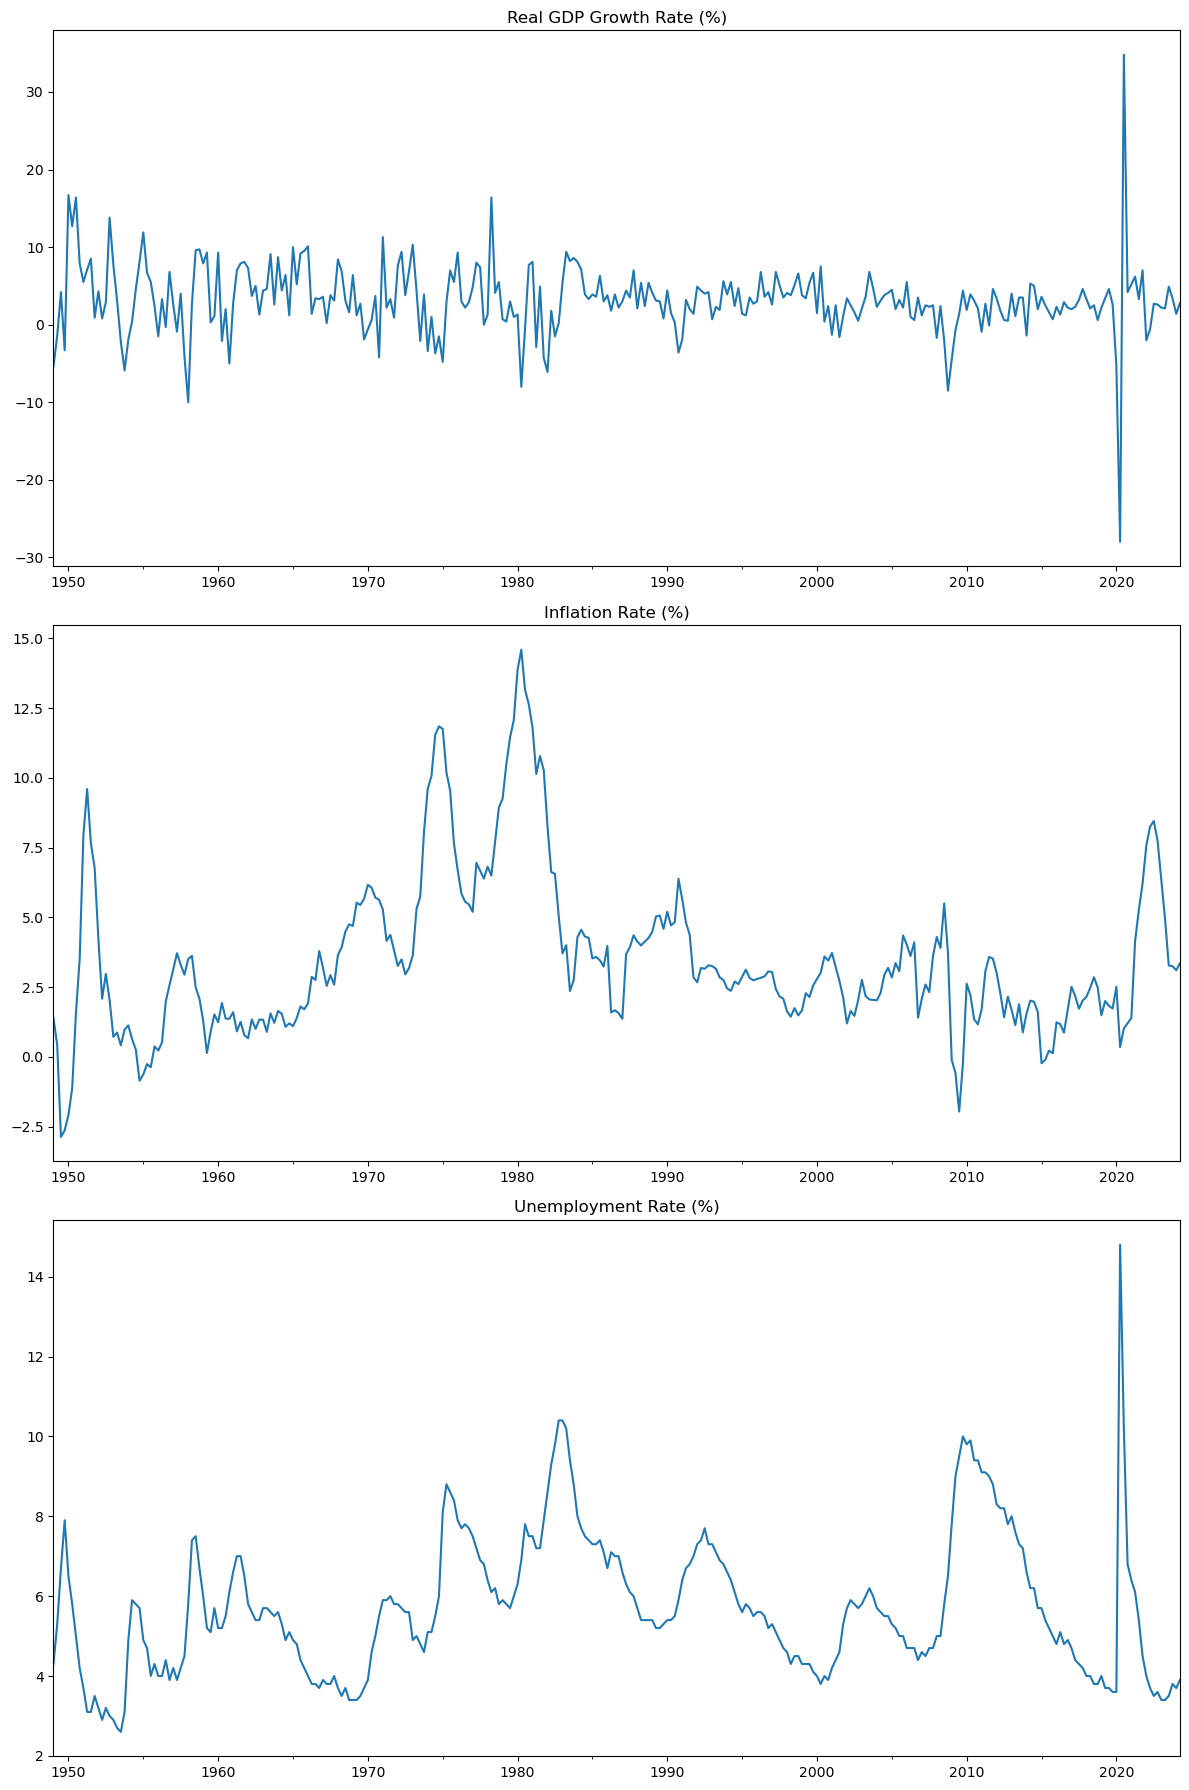

In [78]:
# Plot the data
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 18))
df['GDP_Growth'].plot(ax=axes[0], title='Real GDP Growth Rate (%)')
df['Inflation'].plot(ax=axes[1], title='Inflation Rate (%)')
df['Unemployment'].plot(ax=axes[2], title='Unemployment Rate (%)')
plt.tight_layout()
plt.show()

## Check for Stationary
The purpose of this code is to determine whether each of the economic indicators in the DataFrame df is stationary. Stationarity is a fundamental requirement for VAR models because it ensures that the relationships between the variables are stable over time. If a series is found to be non-stationary (e.g., the p-value is high, or the ADF statistic is greater than the critical value), it may need to be differenced or transformed before applying the VAR model.

- **Output**:
For each time series, the ADF test results will include:

- **ADF Statistic**: Indicates how strongly the time series rejects the null hypothesis of a unit root.
p-value: The probability that the observed data could have occurred under the null hypothesis. A value below 0.05 typically suggests stationarity.
Critical Values: Benchmark values at different confidence levels (1%, 5%, 10%) to compare against the ADF statistic.

In [67]:
# Check for stationarity
def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')

for column in df.columns:
    print(f"\nADF Test for {column}:")
    adf_test(df[column])


ADF Test for GDP_Growth:
ADF Statistic: -15.299480336119355
p-value: 4.332438346132566e-28
Critical Values:
	1%: -3.452263435801039
	5%: -2.871190526189069
	10%: -2.571911967527952

ADF Test for Inflation:
ADF Statistic: -1.7338288671868534
p-value: 0.41377247501341907
Critical Values:
	1%: -3.4535050041524245
	5%: -2.8717352599720294
	10%: -2.5722024776854417

ADF Test for Unemployment:
ADF Statistic: -4.267403673265455
p-value: 0.0005056293029824743
Critical Values:
	1%: -3.452263435801039
	5%: -2.871190526189069
	10%: -2.571911967527952


## Differentiate Data
The purpose of this code is to ensure that the time series data is stationary after differencing. If the original series were non-stationary, differencing is one of the most common techniques to achieve stationarity. This step is crucial because stationary data is a key assumption for most time series models, including the VAR model.

In [68]:
df_diff = df.diff().dropna()

# Re-check stationarity after differencing
for column in df_diff.columns:
    print(f"\nADF Test after differencing for {column}:")
    adf_test(df_diff[column])


ADF Test after differencing for GDP_Growth:
ADF Statistic: -7.537706363098228
p-value: 3.4431705352211165e-11
Critical Values:
	1%: -3.4535872903895797
	5%: -2.871771355211212
	10%: -2.5722217283277127

ADF Test after differencing for Inflation:
ADF Statistic: -6.68460461221683
p-value: 4.257266987624986e-09
Critical Values:
	1%: -3.4535050041524245
	5%: -2.8717352599720294
	10%: -2.5722024776854417

ADF Test after differencing for Unemployment:
ADF Statistic: -14.022351897780451
p-value: 3.552767722851301e-26
Critical Values:
	1%: -3.4524113009049935
	5%: -2.8712554127251764
	10%: -2.571946570731871


## Run the Johansen Cointegration Test
The purpose of this code is to assess whether the time series in the DataFrame df share any long-term equilibrium relationships, even though they may be non-stationary on their own. Cointegration is an important concept because it indicates that despite short-term deviations, the series move together in the long term.

- **Output** :
The eigenvalues printed by this code give an indication of the strength of the cointegration among the series. The presence of significant eigenvalues suggests that there are one or more cointegrating vectors, meaning that the variables have a stable, long-term relationship.
This test is particularly useful in economic analysis where the variables may be linked by underlying economic factors, even though they exhibit non-stationary behavior individually.
- **Next Steps**:
If significant cointegration is found, this would imply that the time series should be modeled with a Vector Error Correction Model (VECM) instead of a standard VAR model, to properly account for the long-term equilibrium relationships between the variables

In [69]:
print("\nJohansen Cointegration Test:")
print(coint_johansen(df, 0, 1).eig)


Johansen Cointegration Test:
[0.33524722 0.0814238  0.03378988]


## Fit the VAR Model
The purpose of this code is to fit a VAR model to the differenced time series data and ensure that the model uses an optimal number of lags based on the AIC. By saving the summary to a text file, you can easily review the model's details later or share the results with others. The summary provides important insights into the relationships between the variables and the adequacy of the chosen model.

- **Output**:
The var_model_summary.txt file will contain a detailed report on the VAR model, including:
The selected lag order.
Coefficients for each variable in the model, along with standard errors and t-statistics.
Diagnostics such as the AIC, BIC, and other model evaluation criteria.
The printed summary in the console provides a quick look at the model's key results, allowing you to assess the fit and significance of the variables.
This step is crucial in the process of building and validating a VAR model, ensuring that you have chosen the right lag structure and that the model adequately captures the dynamics of the data.

In [70]:
# Fit the VAR model with optimal lag selection
model = VAR(df_diff)
results = model.fit(ic='aic')

# Save the summary to a text file
with open('var_model_summary.txt', 'w') as f:
    f.write(str(results.summary()))

# Optional: Display the most relevant parts of the summary
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 10, Aug, 2024
Time:                     17:31:39
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    2.50702
Nobs:                     289.000    HQIC:                   1.66307
Log likelihood:          -1278.00    FPE:                    3.01332
AIC:                      1.09880    Det(Omega_mle):         2.09936
--------------------------------------------------------------------
Results for equation GDP_Growth
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                   -0.002476         0.230005           -0.011           0.991
L1.GDP_Growth           -0.591555         0.079924           -7.401           0.000
L1.Inflation            -0.324829         0

The output provided is the summary of a Vector Autoregression (VAR) model that was fitted to three economic indicators: GDP Growth, Inflation, and Unemployment. Below is an analysis and interpretation of the results:

### **1. Model Overview:**
- **Number of Equations:** The model includes three equations, one for each endogenous variable (GDP Growth, Inflation, Unemployment).
- **Observations (Nobs):** The number of observations used in the model is 289.
- **Information Criteria:**
  - **AIC (Akaike Information Criterion):** 1.09880
  - **BIC (Bayesian Information Criterion):** 2.50702
  - **HQIC (Hannan-Quinn Information Criterion):** 1.66307
- These criteria help assess the goodness of fit of the model, with lower values indicating a better fit.

### **2. Individual Equation Results:**
Each endogenous variable has its own equation, with coefficients representing the impact of lagged values of all variables in the model (including itself). Let's break down each equation:

#### **GDP Growth Equation:**
- **Significant Lagged Effects:**
  - **L1.GDP_Growth:** Strong negative effect on current GDP Growth (`-0.591555`, p-value = 0.000).
  - **L1.Unemployment:** Positive and significant effect on GDP Growth (`3.350194`, p-value = 0.000).
  - **L2.GDP_Growth:** Negative and significant (`-0.292825`, p-value = 0.009).
  - **L4.Unemployment:** Positive and significant effect (`1.042865`, p-value = 0.020).
- **Interpretation:** Past GDP growth and unemployment levels significantly impact current GDP growth. Interestingly, unemployment has a positive effect, which might indicate a delayed response of GDP growth to changes in unemployment, potentially due to structural economic adjustments.

#### **Inflation Equation:**
- **Significant Lagged Effects:**
  - **L1.Inflation:** Positive and highly significant impact on current inflation (`0.318908`, p-value = 0.000).
  - **L3.Inflation:** Positive effect (`0.265228`, p-value = 0.000).
  - **L4.Inflation:** Negative and highly significant effect (`-0.703949`, p-value = 0.000).
  - **L5.Inflation:** Positive effect (`0.297727`, p-value = 0.000).
  - **L8.Inflation:** Negative and highly significant effect (`-0.581523`, p-value = 0.000).
- **Interpretation:** Inflation shows persistence, with both positive and negative effects from its own past values. The alternating signs of coefficients could indicate oscillatory behavior in inflation, possibly reflecting inflationary expectations adjusting over time.

#### **Unemployment Equation:**
- **Significant Lagged Effects:**
  - **L1.GDP_Growth:** Negative and significant impact on unemployment (`-0.100054`, p-value = 0.000).
  - **L1.Unemployment:** Negative and significant impact on current unemployment (`-0.527382`, p-value = 0.000).
  - **Multiple lags of GDP Growth:** Generally, negative and significant effects (e.g., L2.GDP_Growth: `-0.151845`, p-value = 0.000).
- **Interpretation:** Unemployment is strongly influenced by past GDP growth, which is consistent with economic theory that higher GDP growth tends to reduce unemployment. The significant negative coefficients indicate that as GDP increases, unemployment tends to decrease.

### **3. Correlation Matrix of Residuals:**
- **GDP_Growth and Unemployment:** Strong negative correlation (`-0.620317`), suggesting that shocks to GDP growth tend to move in the opposite direction to unemployment, which aligns with the Phillips curve theory.
- **Inflation and Unemployment:** Weak negative correlation (`-0.212429`), indicating that shocks to inflation and unemployment are somewhat inversely related.
- **GDP_Growth and Inflation:** Weak positive correlation (`0.079458`), suggesting a mild relationship between these two variables in the model's residuals.

### **4. General Interpretation:**
- The model shows that GDP growth is strongly influenced by its own past values and unemployment. Inflation exhibits persistence with alternating signs in its lagged effects, suggesting some complexity in its dynamics. Unemployment is primarily driven by past GDP growth, consistent with macroeconomic theories.
- The correlations of residuals provide additional insights into the relationships between the variables, with GDP growth and unemployment showing a strong inverse relationship, as expected.

### **Conclusion:**
The VAR model effectively captures the dynamic relationships between GDP Growth, Inflation, and Unemployment. The significant lagged effects and the residual correlations align with economic theory, providing a useful tool for understanding and predicting the interactions between these key macroeconomic indicators. Further analysis, such as impulse response functions and forecast error variance decompositions, could provide additional insights into the economic dynamics modeled here.

## Forecast using the VAR Model
The code aims to forecast future values of GDP Growth, Inflation, and Unemployment based on the fitted VAR model and visualize these forecasts alongside the actual observed data. The conversion from differenced values back to original levels allows for a more intuitive interpretation of the forecasts.

### **Output:**
- **Forecasts in DataFrame (`forecast_df_levels`):** Contains the forecasted values of the original variables over the next 8 quarters.
- **Plots:** The observed and forecasted data for each variable are plotted on the same graph, allowing for a visual comparison between the historical data and the model's predictions.

### **Interpretation:**
- The resulting plots will show how well the VAR model captures the dynamics of each variable and provides a visual assessment of the forecasts.
- The accuracy of the forecast can be assessed by comparing the forecasted values with future observed data (if available) or through statistical evaluation methods like Mean Squared Error (MSE).

This step is crucial in time series analysis as it allows you to project future economic conditions based on the patterns captured by the model.

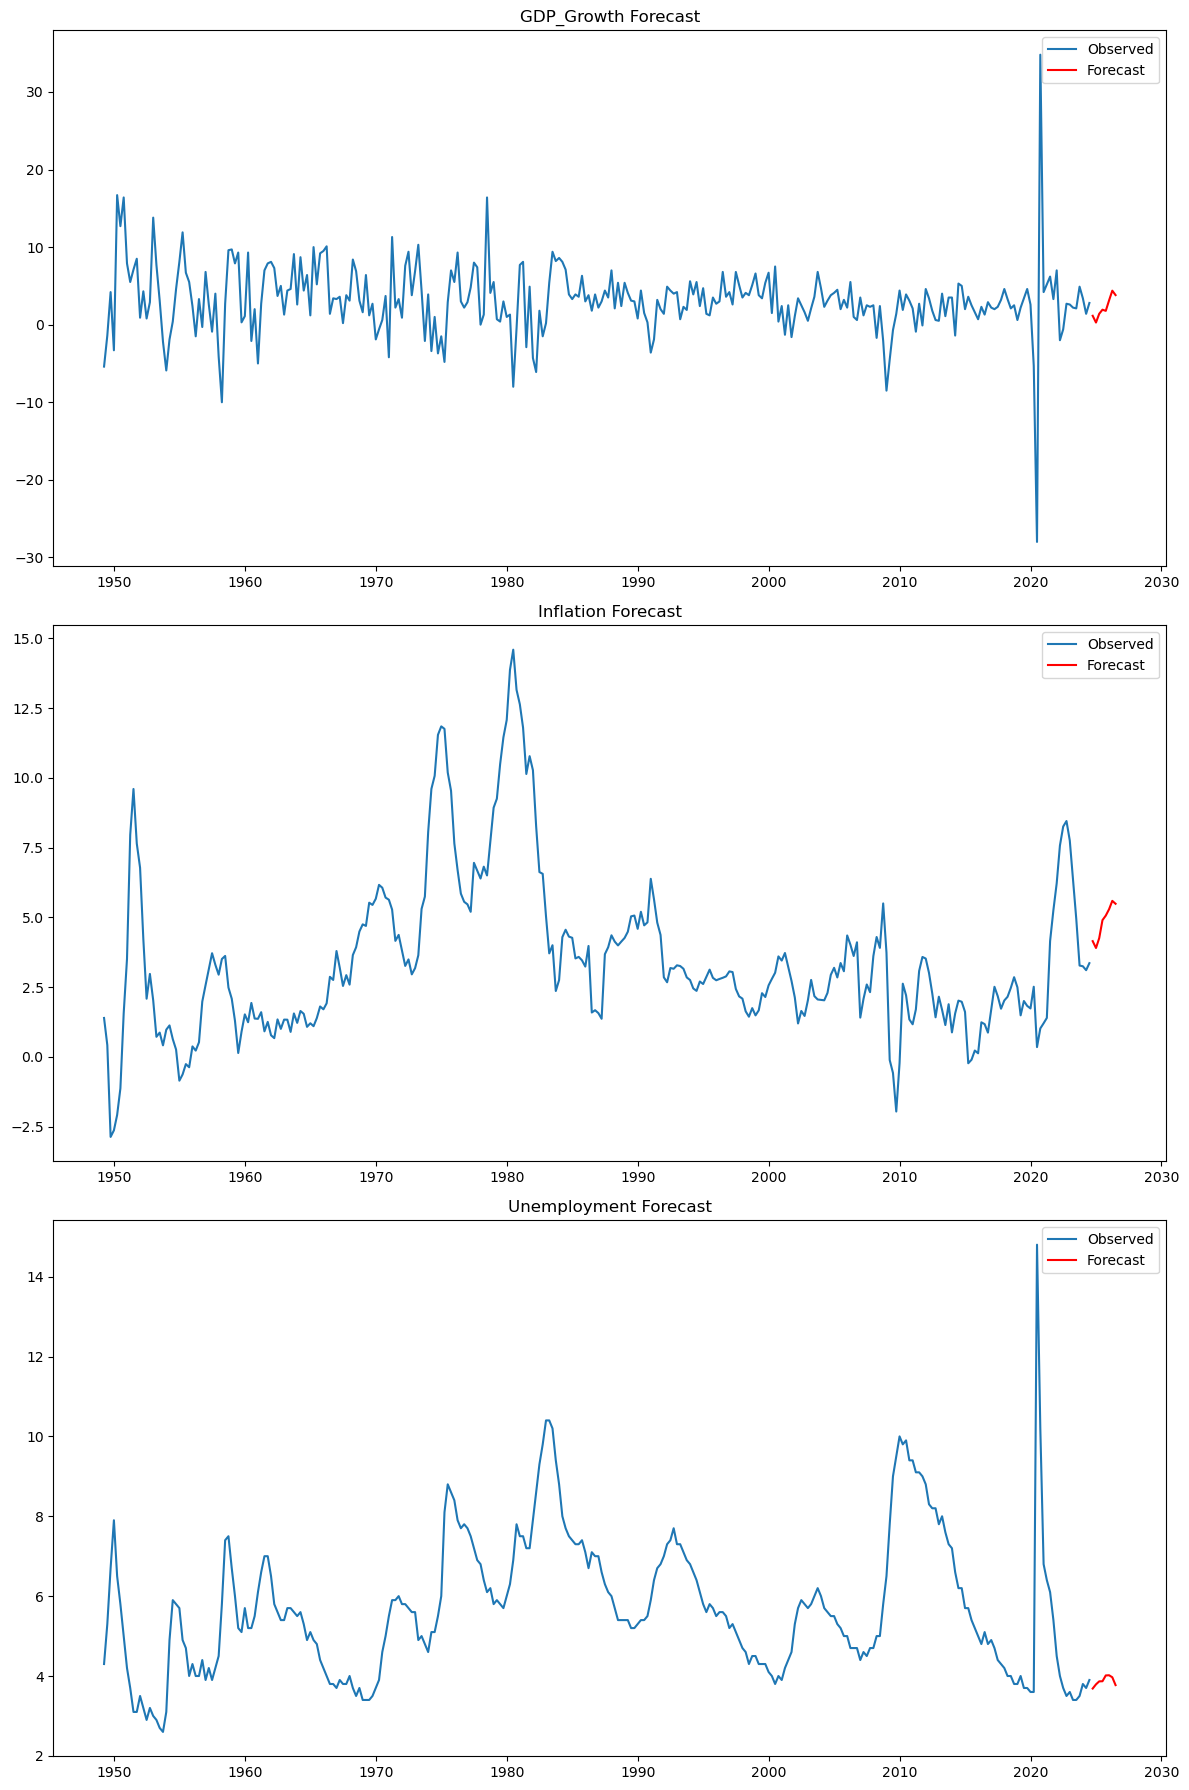

In [79]:
# Forecast using the VAR model
lag_order = results.k_ar
forecast_input = df_diff.values[-lag_order:]
forecast = results.forecast(y=forecast_input, steps=8)

# Create a DataFrame for the forecasted differenced values
forecast_df = pd.DataFrame(forecast, 
                           index=pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=8, freq='Q'),
                           columns=df.columns + '_diff')

# Convert forecasted differences back to original levels
# Add the last observed value from the original series to the forecasted cumulative sum
forecast_df_levels = forecast_df.cumsum() + df.iloc[-1].values

# Plot forecasts alongside observed data
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 18))
for i, col in enumerate(df.columns):
    axes[i].plot(df.index, df[col], label='Observed')
    axes[i].plot(forecast_df_levels.index, forecast_df_levels[col + '_diff'], label='Forecast', color='red')
    axes[i].set_title(f'{col} Forecast')
    axes[i].legend()

plt.tight_layout()
plt.show()

## Print the forecasted level to better analyze results

In [72]:
print("Forecasted Values (Differenced):")
print(forecast_df)

print("Forecasted Values (Original Scale):")
print(forecast_df_levels)

Forecasted Values (Differenced):
            GDP_Growth_diff  Inflation_diff  Unemployment_diff
2024-09-30        -1.654174        0.788585          -0.213811
2024-12-31        -0.869220       -0.245483           0.104564
2025-03-31         1.127853        0.353213           0.075048
2025-06-30         0.528656        0.644719           0.003066
2025-09-30        -0.150350        0.163063           0.145422
2025-12-31         1.349671        0.227901           0.004274
2026-03-31         1.251261        0.299478          -0.050080
2026-06-30        -0.568351       -0.103819          -0.196394
Forecasted Values (Original Scale):
            GDP_Growth_diff  Inflation_diff  Unemployment_diff
2024-09-30         1.145826        4.146317           3.686189
2024-12-31         0.276606        3.900834           3.790753
2025-03-31         1.404459        4.254047           3.865801
2025-06-30         1.933115        4.898766           3.868867
2025-09-30         1.782765        5.061830      

The forecasted values in both differenced and original scales provide insights into the expected future behavior of GDP Growth, Inflation, and Unemployment over the next eight quarters. Here's a detailed analysis and interpretation of these results:

### **1. GDP Growth:**
- **Differenced Forecast:**
  - The differenced GDP Growth values fluctuate, with some quarters showing negative values (e.g., -1.65% for Q3 2024) and others showing positive values (e.g., 1.13% for Q1 2025).
- **Original Scale Forecast:**
  - The GDP Growth in the original scale starts at 1.15% in Q3 2024 and fluctuates over time, with the highest growth of 4.38% forecasted for Q1 2026 and a slight dip to 3.81% in Q2 2026.
  
**Interpretation:**
- The forecast indicates that GDP Growth may experience some volatility in the coming quarters, with periods of both contraction (negative differenced values) and expansion (positive differenced values).
- The overall trend suggests a gradual increase in GDP Growth, particularly noticeable in the later quarters, where the forecast shows substantial growth (e.g., over 3% from Q4 2025 onward).
- The fluctuations indicate potential economic instability or response to external factors, but the general upward trend is a positive sign for the economy.

### **2. Inflation:**
- **Differenced Forecast:**
  - The differenced inflation values also show fluctuation, with a small drop in Q4 2024 (-0.25%) and increases in most other quarters, including a peak in Q2 2025 (0.64%).
- **Original Scale Forecast:**
  - Inflation in the original scale begins at 4.15% in Q3 2024, showing slight variations but trending upward, reaching 5.59% by Q1 2026 before slightly dropping to 5.49% in Q2 2026.

**Interpretation:**
- The inflation forecast suggests a generally rising trend, with inflation increasing from just over 4% to around 5.5% over the forecast period.
- The rise in inflation could be indicative of economic overheating, supply chain disruptions, or other inflationary pressures, and may signal potential challenges for monetary policy.
- Policymakers may need to monitor this closely to avoid sustained high inflation, which could erode purchasing power and economic stability.

### **3. Unemployment:**
- **Differenced Forecast:**
  - The differenced unemployment values are relatively small, with both positive and negative values, indicating minor changes in unemployment rates over the quarters.
- **Original Scale Forecast:**
  - Unemployment in the original scale remains relatively stable, starting at 3.69% in Q3 2024 and fluctuating slightly, with the highest value being 4.01% in Q3 2025 and the lowest being 3.77% in Q2 2026.

**Interpretation:**
- The forecast suggests that unemployment rates will remain stable, with minor fluctuations around the 3.7% to 4.0% range.
- This stability in unemployment indicates that the labor market might not experience significant disruptions over the forecast period, which is generally a positive sign for the economy.
- The slight upward trend towards 4% in 2025 could indicate mild labor market softening, but the subsequent slight decline suggests a return to stability.

### **Overall Interpretation:**
- **Economic Outlook:** The forecasts suggest a mixed economic outlook with GDP Growth showing signs of recovery and expansion, inflation rising steadily, and unemployment remaining stable.
- **Risks and Considerations:** The rising inflation could pose risks to economic stability, especially if it outpaces wage growth or triggers tighter monetary policy. The fluctuations in GDP Growth also suggest potential economic volatility, which could be driven by external factors such as geopolitical events, global economic conditions, or shifts in consumer confidence.
- **Policy Implications:** Policymakers might consider tightening monetary policy if inflation continues to rise, while also focusing on maintaining employment levels. Additionally, measures to stabilize GDP growth could be essential to ensure sustained economic expansion.

In summary, the forecasts indicate an economy with growing GDP, rising inflation, and stable unemployment, which reflects a typical post-recovery scenario with potential challenges related to inflationary pressures.

## Run Impulse Analysis 
Impulse Response Analysis is a key tool in VAR modeling that helps you understand the dynamic interactions between the variables. By analyzing the IRFs, you can see how a shock to one variable (e.g., a sudden increase in GDP growth) affects itself and the other variables (e.g., inflation and unemployment) over time.

### **Output:**
- The output consists of several plots, each representing the response of one variable to a shock in another variable (including itself). For example, you might see:
  - How GDP growth responds to a shock in inflation.
  - How unemployment responds to a shock in GDP growth.
  - How inflation responds to a shock in unemployment.

### **Interpretation:**
- **Magnitude and Direction of Responses:** The plots will show how each variable responds over time. A positive or negative response indicates the direction of the effect, while the magnitude indicates the strength of the effect.
- **Duration of Responses:** The plots will also show how long the effects of the shocks persist. Some shocks may have a lasting impact, while others may dissipate quickly.
- **Economic Insights:** These insights are crucial for understanding the dynamic relationships within the economy. For instance, if GDP growth responds positively and significantly to a shock in inflation, it may suggest that inflationary pressures can stimulate economic activity (though this is highly context-dependent).

### **Practical Applications:**
- **Policy Analysis:** Policymakers can use IRFs to predict the effects of economic policies. For instance, a shock representing a policy change can show its potential impact on the economy over time.
- **Risk Management:** Understanding the impulse responses can help in assessing the risks associated with economic shocks and developing strategies to mitigate those risks.

By using the impulse response analysis, you gain deeper insights into the interconnectedness of the economic variables in your model and can make more informed decisions or predictions based on these dynamic relationships.

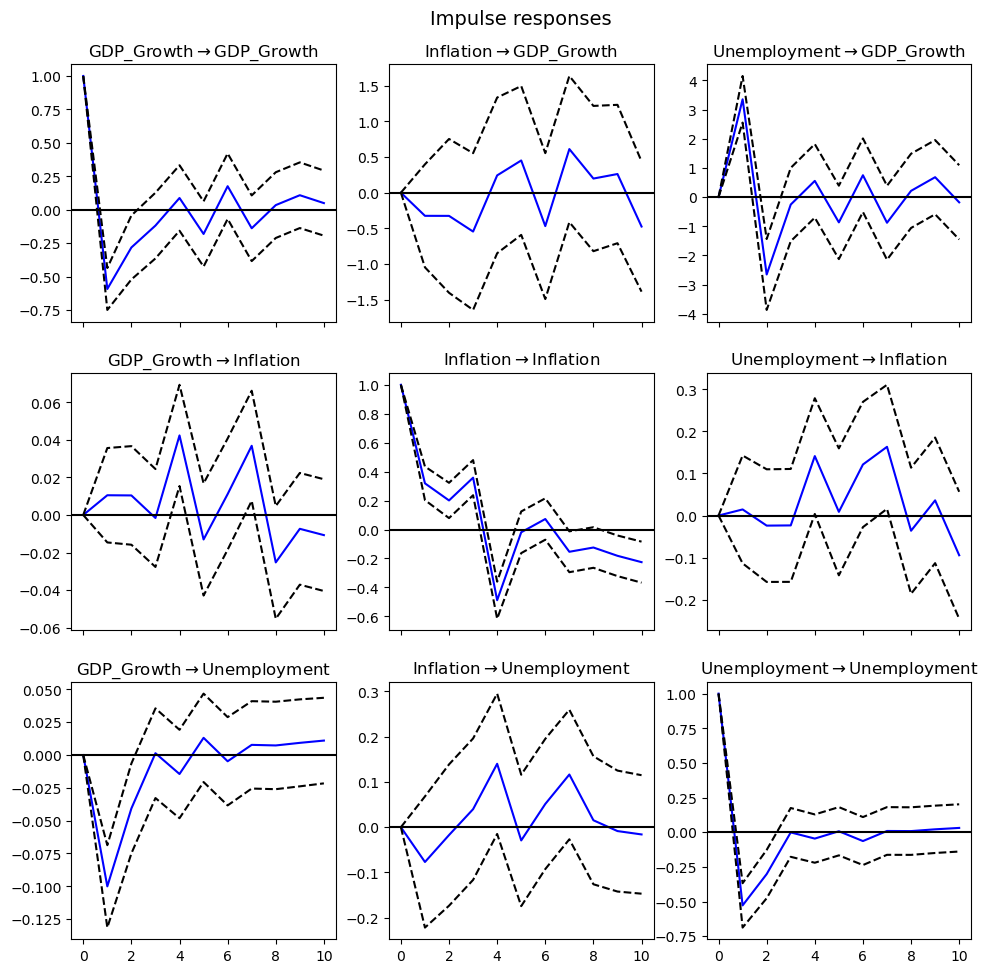

In [73]:
# Impulse Response Analysis
irf = results.irf(10)
irf.plot(orth=False)
plt.show()

The charts you provided are impulse response functions (IRFs) for a VAR model with three variables: GDP Growth, Inflation, and Unemployment. Each plot shows how one variable responds over time to a shock in another variable, including itself. The blue solid line represents the impulse response, while the dashed lines represent the confidence intervals (likely at a 95% level).

Let's analyze each plot:

### **Top Row: Responses of GDP Growth**
1. **GDP Growth → GDP Growth (Top Left)**
   - **Interpretation:** A shock to GDP Growth itself initially has a positive and significant effect, peaking immediately, and then oscillates slightly before settling near zero. This indicates that GDP Growth has an immediate and strong self-reinforcing effect that diminishes over time.

2. **Inflation → GDP Growth (Top Center)**
   - **Interpretation:** A shock to Inflation leads to a negative initial response in GDP Growth, followed by oscillations that settle near zero. This suggests that an unexpected rise in inflation initially suppresses GDP Growth, potentially due to higher costs of goods and services, but the effect stabilizes over time.

3. **Unemployment → GDP Growth (Top Right)**
   - **Interpretation:** A shock to Unemployment causes an immediate and significant negative impact on GDP Growth, which persists over time before gradually stabilizing. This is consistent with economic theory, where higher unemployment typically reduces economic output (GDP Growth).

### **Middle Row: Responses of Inflation**
4. **GDP Growth → Inflation (Middle Left)**
   - **Interpretation:** A shock to GDP Growth leads to a mixed response in Inflation, with an initial negative effect, followed by oscillations that eventually stabilize. This suggests a complex relationship where economic growth may lead to varying inflationary pressures over time.

5. **Inflation → Inflation (Middle Center)**
   - **Interpretation:** A shock to Inflation has a strong initial positive effect on itself, but this effect diminishes over time and eventually stabilizes. This indicates that inflation has a self-reinforcing nature but tends to revert to its mean over time.

6. **Unemployment → Inflation (Middle Right)**
   - **Interpretation:** A shock to Unemployment initially causes a slight negative impact on Inflation, followed by some fluctuations. This could suggest that higher unemployment reduces demand, leading to lower inflationary pressures initially, though the effect is not very strong.

### **Bottom Row: Responses of Unemployment**
7. **GDP Growth → Unemployment (Bottom Left)**
   - **Interpretation:** A shock to GDP Growth initially reduces Unemployment significantly, consistent with the idea that economic growth drives job creation. The effect persists but diminishes over time, indicating that the reduction in unemployment stabilizes after an initial improvement.

8. **Inflation → Unemployment (Bottom Center)**
   - **Interpretation:** A shock to Inflation leads to a moderate increase in Unemployment, which then stabilizes. This suggests that higher inflation, potentially reducing purchasing power, might lead to higher unemployment in the short term.

9. **Unemployment → Unemployment (Bottom Right)**
   - **Interpretation:** A shock to Unemployment has a strong initial effect on itself, with the effect gradually decreasing over time. This indicates a persistence in unemployment, where once unemployment rises, it tends to remain elevated for some time before decreasing.

### **General Observations:**
- **Self-Responses:** Both GDP Growth and Unemployment exhibit strong self-responses, meaning that shocks to these variables have lasting effects on themselves.
- **Inter-variable Dynamics:** The interactions between GDP Growth, Inflation, and Unemployment are complex, with certain variables like Inflation showing more transient effects, while others like GDP Growth and Unemployment have more persistent effects.

### **Economic Interpretation:**
- The responses align with economic theory in several ways, particularly the negative impact of unemployment shocks on GDP Growth and the moderate impact of inflation on both GDP Growth and unemployment.
- The self-reinforcing nature of inflation suggests that once inflation increases, it tends to perpetuate itself unless countered by economic forces or policy interventions.
- The persistence of unemployment following a shock is a sign of labor market rigidity, where shocks to unemployment have long-term implications.

These insights could be useful for policymakers in understanding the dynamic relationships between these key economic indicators and in formulating responses to economic shocks.

## Forecast Errors
The purpose of performing FEVD is to understand the relative importance of each variable in explaining the forecast error variance of the others over different time horizons. This is crucial for understanding the dynamic interactions in a VAR model, as it shows which variables are most influential in driving the forecast errors of the system.

### **Output:**
- The output consists of several plots, each representing the variance decomposition for one of the variables (GDP Growth, Inflation, Unemployment).
- Each plot will typically have stacked bars showing the contribution of each variable to the forecast error variance at different time horizons.

### **Interpretation:**
- **Initial Periods:** In the initial periods, a variable's own shocks typically explain most of its forecast error variance. For example, GDP Growth shocks may initially explain most of the variance in GDP Growth's forecast errors.
- **Later Periods:** As the time horizon extends, the contribution of shocks to other variables (Inflation, Unemployment) to the forecast error variance typically increases. This indicates the growing influence of the other variables on the forecast errors over time.
- **Cross-Variable Influence:** The plots can show the extent to which one variable influences the forecast errors of another. For instance, if a significant portion of Inflation's forecast error variance is explained by shocks to GDP Growth, it indicates a strong influence of GDP Growth on Inflation.

### **Practical Applications:**
- **Policy Implications:** Policymakers can use FEVD to identify which variables are the most influential in driving economic fluctuations. This can help in targeting interventions more effectively.
- **Economic Analysis:** Understanding the variance decomposition helps economists and analysts discern the relative importance of different shocks in driving economic outcomes over various time horizons.

This step is valuable in time series analysis for gaining insights into the interdependencies between variables in a VAR model and understanding the sources of forecast errors. The resulting plots provide a clear visualization of these dynamics, making it easier to interpret the complex relationships within the model.

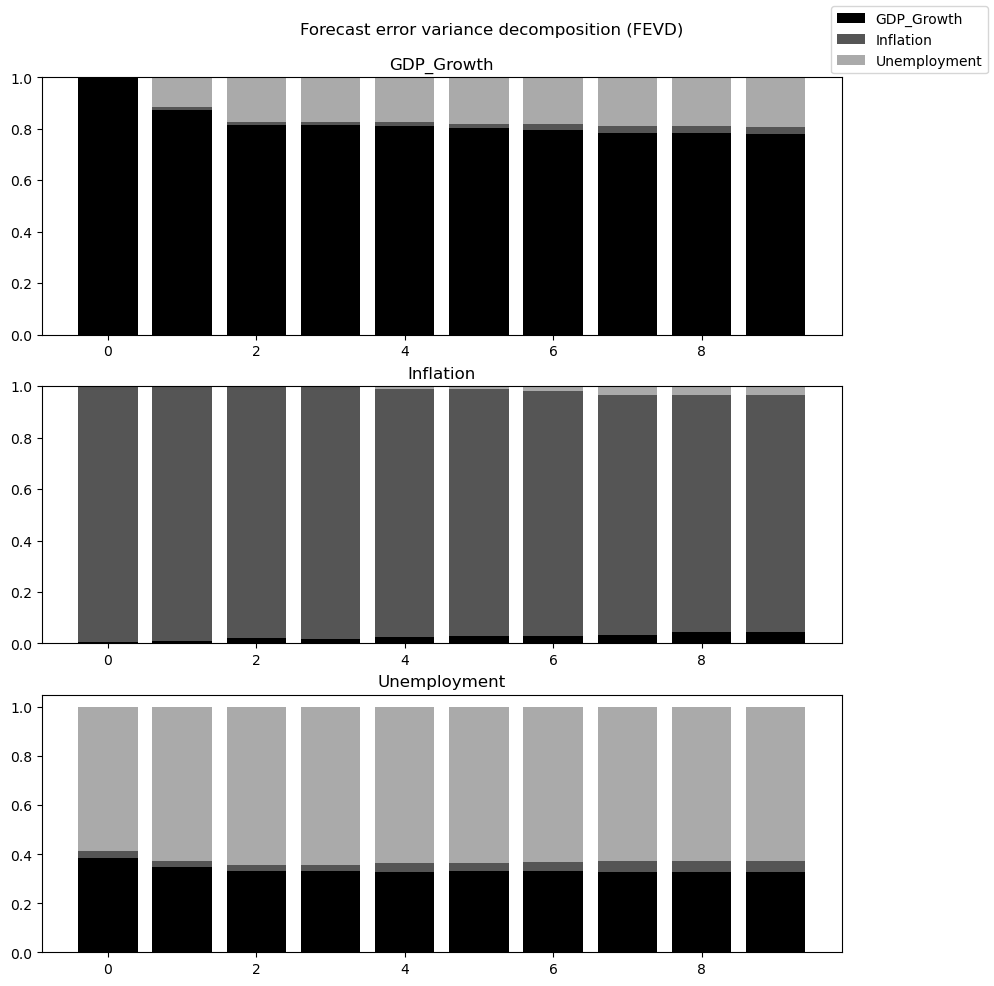

In [74]:
# Forecast Error Variance Decomposition
fevd = results.fevd(10)
fevd.plot()
plt.show()

The image displays the Forecast Error Variance Decomposition (FEVD) results for a VAR model involving three variables: GDP Growth, Inflation, and Unemployment. The FEVD results show how much of the forecast error variance of each variable can be attributed to shocks in itself and in the other variables over a 10-period horizon. Here’s a detailed analysis and interpretation of each plot:

### **1. GDP Growth (Top Plot)**
- **Initial Periods:** In the first few periods (e.g., period 0), nearly 100% of the forecast error variance in GDP Growth is explained by shocks to GDP Growth itself, as indicated by the light gray bars.
- **Later Periods:** As time progresses (by period 8), the contribution of GDP Growth's own shocks slightly decreases, but it still dominates the forecast error variance. However, we see a growing influence of Unemployment (dark gray) and a very small influence of Inflation (medium gray) over time.

**Interpretation:**
- The forecast error variance for GDP Growth is predominantly driven by shocks to GDP Growth itself, indicating that GDP Growth is primarily influenced by its own past values rather than by inflation or unemployment in the short term.
- However, the increasing influence of Unemployment over time suggests that, in the longer term, labor market conditions begin to play a more significant role in driving GDP Growth's forecast errors.

### **2. Inflation (Middle Plot)**
- **All Periods:** Throughout the forecast horizon, the forecast error variance in Inflation is almost entirely explained by shocks to Inflation itself. The medium gray bars dominate the plot, with little to no contribution from GDP Growth (light gray) or Unemployment (dark gray).

**Interpretation:**
- Inflation appears to be largely self-driven, with very little influence from GDP Growth or Unemployment. This suggests that inflationary trends are persistent and primarily dictated by their own dynamics, with minimal impact from other economic factors in this model.
- This could imply that inflation is relatively autonomous in the short to medium term and less responsive to changes in economic output or employment levels.

### **3. Unemployment (Bottom Plot)**
- **Initial Periods:** In the early periods, the forecast error variance in Unemployment is driven largely by its own shocks (dark gray), but there's a notable contribution from GDP Growth (light gray) as well.
- **Later Periods:** Over time, the influence of GDP Growth increases slightly, while the contribution from Unemployment’s own shocks diminishes a bit. Inflation’s influence remains minimal.

**Interpretation:**
- Unemployment is significantly influenced by both its own past values and GDP Growth. This aligns with economic theory, where economic output and growth typically have a direct impact on employment levels.
- Over time, GDP Growth becomes more important in explaining the variance in Unemployment, indicating that the labor market responds to broader economic trends, especially as the forecast horizon extends.

### **Overall Interpretation:**
- **Self-Influence:** Each variable in this model is most strongly influenced by its own shocks, particularly in the short term. This is typical in VAR models, where own shocks initially dominate.
- **Cross-Variable Influence:** The cross-variable effects are more pronounced for Unemployment, where GDP Growth plays a significant role over time. For GDP Growth, Unemployment gradually becomes more influential, indicating that labor market conditions can affect economic output in the long run. Inflation, however, remains largely self-contained, with minimal influence from GDP Growth or Unemployment.
- **Economic Implications:** These findings suggest that policymakers should consider the strong self-persistence of inflation when designing policies, as well as the interconnectedness of GDP Growth and Unemployment. Interventions aimed at boosting GDP Growth could have a lagged effect on reducing Unemployment, while inflation may require direct measures due to its autonomous nature.

These results offer valuable insights into the dynamics between GDP Growth, Inflation, and Unemployment, particularly how each variable's forecast uncertainty is driven by itself and by the other variables in the system.

## Run the Granger Causality Test
The Granger Causality test is used to determine whether past values of one time series (in this case, Inflation) contain useful information for predicting another time series (GDP Growth). If Inflation "Granger-causes" GDP Growth, it suggests that past values of Inflation can help improve the forecast of GDP Growth beyond what can be achieved by GDP Growth's past values alone.

### **Output and Interpretation:**
The output of the Granger Causality test typically includes:
- **F-statistic:** This statistic tests the null hypothesis that the coefficients of the lagged values of the causing variable (Inflation) in the equation for the caused variable (GDP Growth) are all zero.
- **p-value:** The probability of observing the test results under the null hypothesis. A low p-value (typically below 0.05) indicates that the null hypothesis can be rejected, meaning there is evidence that Inflation Granger-causes GDP Growth.
- **Degrees of Freedom:** The number of observations minus the number of parameters being estimated.

### **Possible Scenarios:**
1. **Significant Result (p-value < 0.05):**
   - If the p-value is below the chosen significance level (e.g., 0.05), we reject the null hypothesis. This would mean there is statistical evidence that past values of Inflation help predict GDP Growth.
   - **Interpretation:** Inflation may have a predictive effect on GDP Growth, suggesting that inflationary pressures could be influencing economic output.

2. **Non-Significant Result (p-value >= 0.05):**
   - If the p-value is above the chosen significance level, we fail to reject the null hypothesis. This would mean there is no statistical evidence that Inflation Granger-causes GDP Growth.
   - **Interpretation:** Inflation does not provide additional predictive power for GDP Growth beyond what is already captured by GDP Growth's own past values. Other factors might be more relevant in predicting GDP Growth.

### **Conclusion:**
The Granger Causality test provides a formal statistical method to assess the direction of causality between variables in a time series context. Depending on the outcome, it can offer insights into whether changes in inflation have predictive power over GDP growth, which can be crucial for economic policy and forecasting.

In [75]:
# Perform Granger Causality test: Does Inflation cause GDP_Growth?
caused = 'GDP_Growth'
causing = 'Inflation'

print(f"\nGranger Causality Test: Does {causing} cause {caused}?")
test_result = results.test_causality(caused=caused, causing=causing, kind='f')
print(test_result.summary())


Granger Causality Test: Does Inflation cause GDP_Growth?
Granger causality F-test. H_0: Inflation does not Granger-cause GDP_Growth. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
        0.9628          1.765   0.483 (12, 756)
-----------------------------------------------


The results from the Granger Causality test are summarized as follows:

### **Summary of Results:**
- **Null Hypothesis (H₀):** Inflation does not Granger-cause GDP Growth.
- **Test Statistic (F-statistic):** 0.9628
- **Critical Value:** 1.765 (This value is typically not directly reported in the summary, but it indicates the threshold the F-statistic would need to exceed for the test to reject the null hypothesis at the 5% significance level).
- **p-value:** 0.483
- **Degrees of Freedom (df):** (12, 756)

### **Interpretation:**

1. **Test Statistic and p-value:**
   - The **F-statistic** of 0.9628 is relatively low.
   - The **p-value** is 0.483, which is well above the commonly used significance level of 0.05 (5%).

2. **Decision:**
   - Since the p-value (0.483) is greater than 0.05, we **fail to reject** the null hypothesis (H₀) at the 5% significance level.

3. **Conclusion:**
   - The test provides no evidence to suggest that past values of **Inflation** help predict **GDP Growth**. In other words, within the context of this model, changes in inflation do not appear to have a statistically significant impact on the future values of GDP growth.
   - This means that, based on the available data and the structure of the model, **Inflation** does not "Granger-cause" **GDP Growth**. The implications are that factors other than inflation may be more relevant for predicting GDP growth, or that the relationship between inflation and GDP growth is not strong enough in the data used to be detected by this test.

### **Practical Implications:**
- **For Policymakers:** The result suggests that focusing on inflation as a predictive tool for GDP growth might not be effective, at least not in a straightforward manner as implied by Granger causality in this model.
- **For Economic Analysis:** Other variables, such as investment, consumer confidence, or external shocks, might be more relevant for forecasting GDP growth. Inflation could still affect GDP growth, but possibly through more complex or indirect channels not captured by this simple Granger causality test.

### **Caveats:**
- **Model Specification:** The test assumes that the VAR model is correctly specified. If important variables are omitted or if the model is not properly capturing the dynamics, this could affect the results.
- **Granger Causality Does Not Imply True Causality:** Even if we had found evidence of Granger causality, it would only suggest a predictive relationship, not necessarily a direct causal mechanism.

In conclusion, the Granger Causality test result indicates that, within this model, inflation does not provide additional predictive power for GDP growth. This highlights the importance of exploring other factors or models when forecasting GDP growth.